In [25]:
# Install and import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

!pip install torch torchvision
!pip install transformers

from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [10]:
# Import and load dataset
!git clone https://github.com/f73chen/SteelHacks
%cd SteelHacks/Fake_and_real_news_dataset/

real = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

Cloning into 'SteelHacks'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
/content/SteelHacks/Fake_and_real_news_dataset


In [11]:
# Make both sets the same length
cutoff = min(len(real), len(fake))
real = real[:cutoff]
fake = fake[:cutoff]

In [12]:
# Add classification label
real['fake'] = False
fake['fake'] = True

In [13]:
# Merge the sets and shuffle order
df = pd.concat([real, fake])
df = shuffle(df).reset_index(drop = True)

In [16]:
# Split into training, validation, and testing
train, val, test = np.split(df.sample(frac = 1), [int(0.6 * len(df)), int(0.8 * len(df))])

train = train.reset_index(drop = True)
val = val.reset_index(drop = True)
test = test.reset_index(drop = True)

del real; del fake

print(f"training set length: {len(train)}")
print(f"validation set length: {len(val)}")
print(f"testing set length: {len(test)}")

training set length: 25700
validation set length: 8567
testing set length: 8567


In [17]:
# Import pre-trained BERT model for transfer learning
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
# Freeze pre-trained weights and add 3 new layers
for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(768, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 2),
                                 nn.Softmax(dim = 1))

model = model.to(device)

In [20]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.01)

In [21]:
def preprocess_text(text):
  parts = []
  text_len = len(text.split(' '))
  delta = 300
  max_parts = 5
  nb_cuts = int(text_len / delta)
  nb_cuts = min(nb_cuts, max_parts)

  for i in range(nb_cuts + 1):
    text_part = ' '.join(text.split(' ')[i * delta : (i+1) * delta])
    parts.append(tokenizer.encode(text_part, return_tensors = "pt",
                                  max_length = 500).to(device))
  return parts

In [24]:
print_every = 300
total_loss = 0
all_losses = []
CUDA_LAUNCH_BLOCKING = 1

model.train()

for i, row in train.iterrows():
  text = preprocess_text(str(row['text']))
  label = torch.tensor([row['fake']]).long().to(device)

  optimizer.zero_grad()

  output = torch.zeros((1, 2)).float().to(device)
  for part in text:
    if len(part > 0):
      try:
        input = part.reshape(-1)[:512].reshape(1, -1)
        output += model(input, labels = label)[1].float().to(device)
      except Exception as e:
        print(str(e))

  output = F.softmax(output[0], dim = -1)

  if label == 0:
    label = torch.tensor([1.0, 0.0]).float().to(device)
  elif label == 1:
    label = torch.tensor([0.0, 1.0]).float().to(device)

  loss = criterion(output, label)
  total_loss += loss.item()

  loss.backward()
  optimizer.step()

  if i % print_every == 0 and i > 0:
    avg_loss = total_loss / print_every
    print("{}/{}. Average loss: {}".format(i, len(train), avg_loss))
    all_losses.append(avg_loss)
    total_loss = 0

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


300/25700. Average loss: 0.24730738694469134
600/25700. Average loss: 0.23601459407558043
900/25700. Average loss: 0.20681377058227857
1200/25700. Average loss: 0.18053815816529095
1500/25700. Average loss: 0.14881129760013814
1800/25700. Average loss: 0.15945958487369352
2100/25700. Average loss: 0.12064189032828532
2400/25700. Average loss: 0.1492676494368061
2700/25700. Average loss: 0.12111088724758398
3000/25700. Average loss: 0.09609953398268166
3300/25700. Average loss: 0.10401090970772202
3600/25700. Average loss: 0.10820656015517063
3900/25700. Average loss: 0.09292697250062096
4200/25700. Average loss: 0.0938761470518269
4500/25700. Average loss: 0.08250889229139527
4800/25700. Average loss: 0.08808765502223347
5100/25700. Average loss: 0.08157614235882647
5400/25700. Average loss: 0.10658250410653029
5700/25700. Average loss: 0.10076413939890093
6000/25700. Average loss: 0.07149609892769755
6300/25700. Average loss: 0.07645434153906536
6600/25700. Average loss: 0.09344378570

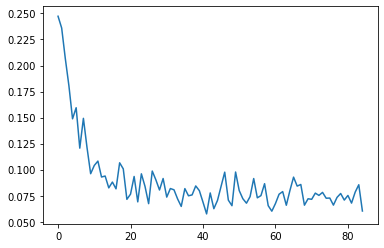

In [26]:
%matplotlib inline
torch.save(model.state_dict(), "trained_model.pt")
plt.plot(all_losses)

In [27]:
# Test accuracy on the test set
total = len(test)
correct = 0
model.eval()

with torch.no_grad():
  for i, row in test.iterrows():
    text = preprocess_text(str(row['text']))
    label = torch.tensor([row['fake']]).float().to(device)
    
    output = torch.zeros((1, 2)).to(device)
    try:
      for part in text:
        if len(part) > 0:
          output += model(part.reshape(1, -1))[0]
    except RuntimeError:
      print("GPU out of memory, skipping this entry.")
      continue

    output = F.softmax(output[0], dim = -1)
    result = output.max(0)[1].float().item()

    if result == label.item():
      correct += 1

    if i % print_every == 0 and i > 0:
      print("{}/{}. Current accuracy: {}".format(i, total, correct / i))

print("Final accuracy on test data: {}".format(correct / total))

300/8567. Current accuracy: 0.9733333333333334
600/8567. Current accuracy: 0.965
900/8567. Current accuracy: 0.9655555555555555
1200/8567. Current accuracy: 0.9625
1500/8567. Current accuracy: 0.9653333333333334
1800/8567. Current accuracy: 0.9661111111111111
2100/8567. Current accuracy: 0.9657142857142857
2400/8567. Current accuracy: 0.9666666666666667
2700/8567. Current accuracy: 0.9674074074074074
3000/8567. Current accuracy: 0.963
3300/8567. Current accuracy: 0.9627272727272728
3600/8567. Current accuracy: 0.9633333333333334
3900/8567. Current accuracy: 0.963076923076923
4200/8567. Current accuracy: 0.9633333333333334
4500/8567. Current accuracy: 0.9637777777777777
4800/8567. Current accuracy: 0.9633333333333334
5100/8567. Current accuracy: 0.9631372549019608
5400/8567. Current accuracy: 0.9629629629629629
5700/8567. Current accuracy: 0.9635087719298245
6000/8567. Current accuracy: 0.9631666666666666
6300/8567. Current accuracy: 0.9626984126984127
6600/8567. Current accuracy: 0.962

In [32]:
def test(text):
  text = preprocess_text(text)
  output = torch.zeros((1, 2)).to(device)
  try:
    for part in text:
      if len(part) > 0:
        output += model(part.reshape(1, -1))[0]
  except RuntimeError:
    print("GPU out of memory, skipping this entry.")

  output = F.softmax(output[0], dim = -1)
  val, res = output.max(0)

  term = "real" if res.item() == 0 else "fake"
  print("{} at {}%".format(term, val.item() * 100))

In [33]:
# From original notebook
fake1 = """
Americans to fund killing babies in abortion that she has been caught trying to add taxpayer financing of abortions to the bill to combat the Coronavirus and provide economic stimulus to the nation as it deals with the COVD-19 outbreak.
Nancy Pelosi has a long history of promoting abortion and her first act after becoming Speaker in 2019 was pushing legislation to use tax money for abortions. So it’s no surprise she is trying to exploit the Coronavirus pandemic to push abortion funding again.
As The Daily Caller reports: House Speaker Nancy Pelosi sought to include a potential way to guarantee federal funding for abortion into the coronavirus economic stimulus plan, according to multiple senior White House officials.
Speaking to the Daily Caller, those officials alleged that while negotiating the stimulus with U.S. Treasury Secretary Steve Mnuchin, Pelosi tried to lobby for “several” provisions that stalled bipartisan commitment to the effort. One was a mandate for up to $1 billion to reimburse laboratory claims, which White House officials say would set a precedent of health spending without protections outlined in the Hyde Amendment.
LifeNews depends on the support of readers like you to combat the pro-abortion media. Please donate now.
“A New mandatory funding stream that does not have Hyde protections would be unprecedented,” one White House official explained. “Under the guise of protecting people, Speaker Pelosi is working to make sure taxpayer dollars are spent covering abortion—which is not only backwards, but goes against historical norms.”
A second White House official referred to the provision as a “slush fund” and yet another questioned “what the Hyde Amendment and abortion have to do with protecting Americans from coronavirus?”
Americans should insist to their members of Congress that we need a clean bill that provides aggressive action to help patients and spur the economy. Killing babies with our tax dollars is not the answer to the coronavirus and the situation should not be exploited for political gain.
"""

true1 = """
Price spikes, however, would cause demand to wither and some expensive avocados might be leftover, and stores might try to ration avocados, he added.
"Exactly what the retail strategy would be in this case, I’m not sure. But we would have vastly fewer avocados," Sumner said.
Just how fast avocados would disappear, if at all, would depend on whether the Trump administration enacts a full or partial border closure. White House economic adviser Larry Kudlow told CNBC he’s looking for ways to keep some commerce flowing.
"We are looking at different options, particularly if you can keep those freight lanes, the truck lanes, open," he said this week.  
Ben Holtz owns Rocky H Ranch, a 70-acre family-run avocado farm in northern San Diego County. He agreed avocados would run out within weeks.
"Mexico is the big player today. California is not. You shut down the border and California can’t produce to meet the demand," Holtz said. "There will be people without their guacamole."
While Mexico’s avocado harvest is year-round, California’s is limited to April through July. Growers in the state have picked only about 3 percent of what’s expected to be a much smaller crop of about 175 million pounds this year, Holtz said. A heat wave last summer reduced the crop size.
California’s avocado harvest has averaged approximately 300 million pounds in recent years, according to data from the California Avocado Commission. By contrast, the U.S. has imported more than 1.5 billion pounds of avocados from Mexico annually. Representatives from the commission did not respond to requests for this article.
Altogether, the U.S. received 43 percent of its fruit and vegetable imports from Mexico in 2016, according to the U.S. Department of Agriculture.
Also affecting this year’s avocado supply, a California avocado company in March recalled shipments to six states last month after fears the fruit might be contaminated with a bacterium that can cause health risks.
Until the early 2000s, California was the nation’s leading supplier of avocados, Holtz said. Mexico gradually overtook the state and now dominates sales in the U.S.
"It’s a very big possibility," Holtz said of avocado shortages. "Three weeks would dry up the Mexican inventory. California alone consumes more avocados than are grown in our state. Cold storage supply chain is basically three weeks or less of inventory. Most of the time it’s seven days."
A spokeswoman for the California Restaurant Association said "we haven’t heard concerns from restaurants, it doesn’t mean they aren’t worried." A national grocers association said it will "continue to closely monitor any developments" at the border, but did not have information about the potential impact on avocados.
"""

test(fake1)
test(true1)

real at 50.08867383003235%
real at 87.96486854553223%


In [35]:
# From prof's twitter
real2 = """
Auto Dinosaurs Show They’re Not Dead Yet
Daimler reported unexpectedly strong profits, underlining a rebound by traditional carmakers despite the pandemic.
A year ago, investors had pretty much given up the big global carmakers for dead. Shares of Daimler, General Motors and Ford Motor were at 10-year lows. Electric vehicle start-ups without any sales were sometimes worth more than traditional automakers with tens of thousands of employees and factories all over the world. The pandemic looked as if it would seal the dinosaurs’ fate.
But it turns out the old behemoths may not be doomed just yet. Earnings reported by Daimler on Thursday underlined a remarkable comeback by some traditional carmakers. These companies have managed to survive the pandemic, reorient to electric vehicles and convince stock market investors that they are not going to let Tesla take their customers without a fight.
Daimler shares have tripled since hitting a low point in March, and rose again Thursday after the company said net profit for the year increased almost 50 percent to 4 billon euros, or $4.8 billion, from 2019.
General Motors’ shares have also nearly tripled since March. The company beat analysts’ expectations last week when it reported net profit for the fourth quarter of $2.8 billion, against a loss a year earlier.
In addition to making more money than investors thought was possible in a year of turmoil, the two companies, which date to the early 20th century, have been making decisions that show they grasp the technological changes upending the industry.
G.M. shifted perceptions of its commitment to electric vehicles when it said last month that it would phase out vehicles powered by fossil fuels by 2035. Daimler shares spiked after the company said this month that it would split its car and truck divisions into separate companies, each with its own stock listing. Daimler, based in Stuttgart, Germany, makes Mercedes-Benz luxury cars and Freightliner trucks.
Ola Källenius, the Daimler chief executive, said the decision to break up the company was intended to give managers more freedom to react to technological change.
“As the speed of the transformation of the auto industries is picking up,” Mr. Källenius said in an interview, “decision-making speed is crucial.”
G.M.’s promise to swear off fossil fuels, though not for another 14 years, set off a chain reaction in the industry. Ford said Wednesday that by 2030, all its passenger cars sold in Europe would run solely on batteries. Jaguar Land Rover said Monday that all its Jaguar luxury cars and 60 percent of Land Rover luxury S.U.V.s would run solely on batteries by 2030.
Mr. Källenius has avoided making a similar declaration. In many markets where the company is active, there is no infrastructure for electric cars, he pointed out. Therefore, a vow of fossil-fuel abstinence “is not something we should do just to get a headline,” he said.
But all future Mercedes-Benz models will be designed to be electric, Mr. Källenius said. “Our technology path is clear,” he said. “We are going to take a leading position. It’s a tad too early to pick a date for the world when the last combustion engine will leave the production line.”
Investors seem to be rewarding carmakers that show they can build electric cars. Shares of Ford, whose Mustang Mach-E has gotten good reviews, have doubled since hitting their nadir in March. Shares of the French carmaker Renault have also more than doubled since then; its affordable Zoe subcompact was the best-selling battery-powered car in Europe last year.
Daimler will begin selling several new electric vehicles this year, including the Mercedes-Benz EQS, a counterpart to the company’s top-of-the-line S Class car. The EQS will go on sale in the summer for a starting price probably above $100,000.
So far, electric cars are nowhere near as profitable for Daimler and other traditional carmakers as gasoline models. Battery systems are more costly than conventional engines and transmissions, and automakers are still learning how to manufacture electric cars efficiently. It will take time to achieve the profit margins “we’re used to on the internal combustion side,” Mr. Källenius said.
Daimler’s unexpectedly healthy profit in 2020 was the result of old-fashioned cost-cutting rather than any technological breakthrough. The company reduced its work force by 7,000 employees, or 4 percent, and cut the research and development budget, which Mr. Källenius said was still big compared with competitors.
When the pandemic struck, Daimler quickly dialed back production so it was not stuck with unsold vehicles, Mr. Källenius said.
Even after the sharp gains in their share prices, Daimler and G.M. are still worth only about one-tenth as much on the stock market as Tesla, which makes only a tiny fraction as many vehicles. Investors are dazzled by Elon Musk, the Tesla chief executive, and have more faith in a company that makes nothing but electric cars.
As Mr. Källenius conceded, the dinosaurs still have a lot of convincing to do before investors will believe they have as much potential.
“The financial market is going to wait and see a little bit,” he said. “How is this going to play out?”
“Gradually the financial market is starting to look at our technology portfolio, and everything we have in the pipeline,” Mr. Källenius said.
"""

test(real2)

fake at 61.966919898986816%


In [36]:
# From prof's twitter
real3 = """
The question every politician should be asking is, what does Mark Zuckerberg want with us?
This is about more than Facebook and news – it’s about the pursuit of power in a world where companies are stronger than countries
You can say Mark Zuckerberg puts you in mind of a lot of things. An efit of a man police would like to speak to in connection with supermarket food tampering. A pink and overscrubbed supervillain – Lex Loofah – or the classical bust of a Roman emperor who’s paused the rollout of his hair feature, and lists his hobbies as “flaying” and “indifference”.
Ultimately, though, the most alarming way of looking at the Facebook boss is just factually: he’s the world’s most powerful oligarch, selling the lives of 2.7 billion monthly active users to advertisers, and actually modifying the behaviour of those users with a business model that deliberately amplifies incendiary, nasty, and frequently fake and dangerous things because that’s what keeps you on his platform longer. So yes: considering all that, it’s just a comforting cop-out to say “ooh, Zuckerberg looks like the character in a movie who’s just delivered the line ‘leave no trace of the village’”. Forget post-truth. Mark’s basically post-metaphor.
Anyway, Zuckerberg is in the news along with News Corp boss Rupert Murdoch, in a heartwarming generational fight between billionaires for who gets to say: “Bitch, I’m not IN the news, I OWN the news.” In short, Murdoch (and other news publishers) have long demanded Facebook and Google pay for people linking to or discussing their content on their platforms, or including it in search results. Facebook and others have long resisted.
Having failed to thrash out the issue in the thrashing yurt at various barefoot mogul retreats, Murdoch effectively instructed the Australian government to shake down the tech firms to pay publishers for the sharing of links, or stop allowing the practice. Yes, here he comes, Monty Burns-Unit, absolutely refusing to allow the trident to be prised from his claw by the Valley bros. This week, Google chucked him some undisclosed loose change just to shut him up, but Zuckerberg refused, turning off news sharing in Australia and removing most Australian media from its platform, as well as pages run by state health departments, charities and others. Alas, there is outcry, with the publishers seemingly not wanting the thing they said they wanted any more. It’s one of those fights where you’re rooting for the asteroid to end it.
Of course, Facebook is the galactic leader in PR crises. In the company’s short, unimaginably powerful existence, they have made so many monstrous cock-ups and on such grand scales that it seems reasonable to predict the full collapse of human civilisation will be immediately succeeded by a Facebook statement containing the words: “We know we have more work to do.” It’ll probably have been drafted by Nick Clegg, whose political endpoint was always going to be donning Earth’s last crew-necked sweater and doing comms for the apocalypse.
There is widespread outrage around the world over what’s happened in Australia, particularly from politicians still fighting the last war, specifically the one against Murdoch. Here’s some free BREAKING NEWS, guys: you lost that one. And given the scale of your newer foe, well … the tech companies have grown so far past the stage at which, say, oil companies were broken up, or inquiries into Microsoft begun, that humanity should probably stick a fiver on you losing this one too.
The true tragedy, of course, is that these guys have so much in common. Rupert Murdoch recently received the Covid vaccination, which I read on Zuckerberg’s platform means he’s been injected with Bill Gates, a line of medical inquiry I hope to see enthusiastically taken up by anti-vax-adjacent Tucker Carlson on Murdoch’s own Fox News. Can people this ideologically similar really be so far apart? Let’s hope they can still put their differences aside to form some sort of Injustice League.
As for the rest of us, it’s hard being told how beautiful it is to connect by Zuckerberg, whose smile hasn’t connected with his eyes since 2014. If friends are so important to our common goals, how come he doesn’t have any? Maybe commodifying friendship gives Mark the excuse for not partaking in it. You don’t see crack dealers using their own product, as the saying goes.
People often claim you’re frozen developmentally at the time you become famous, which presumably stunts Zuckerberg back at the stage he was in his Harvard dorm room. I can’t believe a product created to rate women has ended up as what the business professor and tech commentator Scott Galloway calls “the biggest prostitute of hate in the history of mankind”. Honestly, what were the chances?
In her book The Boy Kings, Katherine Losse chronicles her time at Facebook, from being one of the firm’s earliest employees to eventually becoming the person Zuckerberg appoints to write in his voice. Losse’s job was to impart Mark’s thoughts on “the way the world was going” to the company and the wider public. When I read the book, it was hard not to deem his personal philosophy nonexistent. It’s like he’s never thought about anything, ever, other than computer science and personal power.
Naturally, Zuckerberg orders Losse to watch The West Wing. This was a while ago, of course, and it wasn’t quite four years ago that Zuckerberg embarked on a US listening tour, taking in “little people” locations like Iowa truck stops. This was widely interpreted as the start of a long run-up at a traditional presidential campaign. We haven’t heard a lot of that talk recently, but it seems reasonable to believe that Zuckerberg has since realised the president is very much junior personnel – something Murdoch understood decades ago, as far as Australian and UK prime ministers were concerned. Never mind truck stops being for little people. Politics is for little people.
Of course, Zuckerberg is sometimes required to visit Washington and attend hearings, occasions for which Nick Clegg dresses the normally T-shirted statesman as the reluctant teenage best man at his mother’s third wedding. But as he accrues more and more unprecedented global power, the question every single politician should be asking themselves, like, yesterday, is: what does Mark Zuckerberg want with us? They should have clicked long ago that he isn’t remotely interested in news as an idea or service. In 2016, Zuckerberg summarily fired the team that curated “trending” news topics and replaced them with an algorithm that promptly began pushing fabricated news, as well as a video of a man wanking with a McChicken Sandwich.
One of several essays Zuckerberg instructed Losse to write in his voice was “Companies over countries”. She resigned without completing it, but not before having asked him if he could expand the slogan. “I think we are moving to a world in which we all become cells in a single organism,” came Mark’s mild reply, “where we can communicate automatically and can all work together seamlessly.” Wow. A vision of our future that has me immediately paging Morpheus. Was Murdoch … was Murdoch actually the blue pill all along?
Marina Hyde is a Guardian columnist
"""

test(real3)

fake at 81.6200315952301%


In [37]:
# From BBC front page
real4 = """
Texas weather: President Biden to declare major disaster
US President Joe Biden is set to declare a major disaster for Texas, clearing the way for more federal funds to be spent on relief efforts.
Power is returning in the state and temperatures are set to rise but some 13 million people are still facing difficulties accessing clean water.
Mr Biden has said he will visit Texas as long as his presence is not a burden on relief efforts.
Nearly 60 deaths have been attributed to cold weather across the US.
White House spokeswoman Jen Psaki confirmed Mr Biden has asked his team to expedite Texas' request for a disaster declaration.
He has also been in touch with the mayors of some of Texas' biggest cities, such as Houston, Austin and Dallas, to ensure they have access to government resources, an administration official said.
Several other southern states hit by snow and ice storms this week have also reported water service outages.
Winter weather has also cut off water in the city of Jackson, Mississippi - home to around 150,000 people - as well as the largest county in Tennessee that includes the city of Memphis, with over 651,000 residents.
Across the US South, a region unaccustomed to such frigid temperatures, people whose pipes have frozen have taken to boiling snow to make water.
What is happening in Texas?
The Southwestern state's energy grid has been overwhelmed by a surge in demand for heat as temperatures plummeted to 30-year lows, hitting 0F (-18C) earlier this week.
As of Friday, about 180,000 homes and businesses in Texas still had no electricity. Amid freezing temperatures earlier this week, as many as 3.3 million were without power.
Around 13 million people - close to half of the state's population - have faced some disruption of water services as hundreds of water systems have been damaged by the freeze.
Austin, the state's capital, lost 325m gallons (1.2bn litres) of water when pipes burst, the city's water director told reporters on Thursday.
Texas' largest city, Houston, is under a so-called "boil water notice", with the US Centers for Disease Control and Prevention (CDC) advising that all water planned for consumption - even if filtered - must be boiled as it may be contaminated.
Officials there say they are working to rapidly distribute bottled water, as well as power generators, to people in need. Breweries and other local businesses have also assisted with efforts to supply drinkable water.
On Friday, Texas Governor Greg Abbott said the state is providing "any and all resources to assist and to accelerate the response at the local level".
State officials could not offer a timeline for exactly when the water would come back on, saying it was a question for local water providers - and many have not yet fully assessed the damage to their systems.
Gov Abbott also said more plumbers are headed to the state. Water pipes have been bursting across Texas due to the freeze, and local plumbers have struggled to meet demand.
Over 320 plumbers have renewed their licences, and the state agencies are working with plumbing companies out-of-state to secure additional help, he said.
As of Friday, storm warnings are still in place across much of Texas, but temperatures will rise in the coming days, according to the National Weather Service (NWS).
The forecaster has also warned of dangerous travel conditions and power outages in eastern parts of the US as another winter storm system is expected to bring heavy snow, freezing rain and ice.
As the state continues to grapple with the weather crisis, Texas Republican Senator Ted Cruz is facing a backlash after he left Houston on Wednesday for a vacation in Mexico with his family.
Mr Cruz apologised on Thursday and returned to the US after initially planning to stay through the weekend.
How deadly has the storm been?
The recorded deaths in Texas include people who have died in traffic accidents, as well as some who suffered carbon monoxide poisoning from running cars and generators indoors to stay warm.
In Harris County, home to Houston, there were more than 300 suspected cases of carbon monoxide poisoning during the cold snap. A local doctor described it as "a mini mass casualty event" to the Houston Chronicle newspaper.
At least four people were killed following a house fire in Houston that officials said may have been sparked by candles.
Separately, police said two men found alongside a Houston highway were believed to have died due to the cold.
An 11-year-old boy died after temperatures outside his unheated mobile trailer home fell to below freezing. Authorities are now investigating whether Cristian Pavon, who was born in Honduras and saw snow for the first time in his life the day before his death, succumbed to hypothermia on Tuesday.
Cristian's three-year-old stepbrother, who was asleep in the same bed as him, was not injured.
Carrol Anderson, a 75-year-old Vietnam War veteran, died in his truck after he ran out of the oxygen tanks he used to breathe and went outside to get a spare.
"He shouldn't have had to die because he couldn't breathe because we didn't have power," his wife of 30 years told the Chronicle.
His death was one of four announced by officials in the Houston region on Thursday.
Two other men died in their homes and another man was found dead in a car park.
Harris County Sheriff Ed Gonzalez emphasised: "The weather is not just cold, it's deadly."
"""

test(real4)

real at 95.2502965927124%


In [38]:
# From Bloomberg front page
real5 = """
No Reprieve for Toronto as Tight Lockdown Extended to March
Ontario’s government has scrapped plans to allow more businesses to reopen in Toronto after city officials warned it would be a deadly mistake.
Stay-at-home orders will remain in place until at least March 8 in Canada’s largest city and financial center, as well as two other regions of the province. Toronto had been expected to return to less-stringent measures on Feb. 22, allowing for limited opening of some retail businesses that have been closed to in-person activity since November.
“These are difficult but necessary decisions, in order to protect against Covid-19 variants and maintain the progress we have all made together,” Health Minister Christine Elliott said in a statement.
The reversal came after municipal officials, including Toronto Mayor John Tory, urged Ontario Premier Doug Ford to slow down reopening plans, which would have allowed struggling retailers to open at 25% capacity.
‘Downright Insulting’
Right now, only essential stores such as supermarkets are allowed to have customers inside; restaurant dining rooms, movie theaters and many other indoor businesses are also closed.
The Canadian Federation of Independent Business lambasted the government’s decision. “Being asked to just hang in there a little longer is an unacceptable and downright insulting response to the thousands of employers and their tens of thousands of employees whose livelihoods are on the line,” the group said in a statement.
The absence of leadership in Ontario is absolutely breathtaking. The government has ceded all responsibility to the economic functioning of the province to unelected local heath officials who refuse even a courtesy discussion with the businesses they are bankrupting. #lockdowns
Toronto’s chief medical officer, Eileen de Villa, has warned the city is in a deceptively dangerous situation. While growth in new Covid-19 cases has slowed, the experience of other countries, including Germany, has shown that new “variants of concern,” or VOCs, are capable of surging with little warning, she said.
As of Feb. 17, 93,850 cases of Covid-19 had been confirmed in Toronto.
Across the province, the number of cases has been declining for weeks. There have been 385 confirmed cases of the U.K. variant of the virus and nine cases of the South African variant, according to government data as of Feb. 18.
The extended lockdown also applies to Peel, a heavily-populated suburban region west of Toronto, and North Bay-Parry Sound.
Vaccine Reduction
Earlier Friday, health officials released estimates that the province will receive about 2.6 million doses of vaccines per month in the second quarter, down from earlier estimates of 5 million a month. But they expect the pace of deliveries and vaccinations to accelerate in July.
Retired General Rick Hillier, who’s in charge of Ontario’s vaccine logistics, said at a news conference Friday it will likely be “well into summer” before younger, less vulnerable people are able to receive a vaccine.
“The number of vaccines, unfortunately, do not support us doing it any faster,” Hillier said.
A spokesperson for the Ontario health ministry said the projection of 2.6 million per month in the second quarter is based on supplies of the two vaccines already approved for use in Canada -- the Pfizer Inc.-BioNTeck shot and the one developed by Moderna Inc. The approval of other vaccines by Canadian authorities could change the numbers.
"""

test(real5)

real at 88.06978464126587%
